In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from  matplotlib.ticker import FuncFormatter
import seaborn as sns
import datetime as dt

In [2]:
cpal = [
    "#3498db", "#e0749d", "#33d3af", "#ffd92f", "#8da0cb", "#fc8d62",
    "#e5c494", "#bababa"
]
sns.set_style("whitegrid")
sns.set_palette(cpal)
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
df = pd.read_csv("/w/drei/aj_esg/events_log.csv.gz", parse_dates=["timestamp"])
df["timestamp"] = pd.to_datetime(
    df["timestamp"].astype(float).astype(int), format="%Y%m%d%H%M%S")
df = pd.get_dummies(df, columns=["action", "group"])
pd.options.display.float_format = '{:,.2f}'.format

| Ratios            | Definition                                                                                |
|-------------------|-------------------------------------------------------------------------------------------|
| clickthrough rate | The proportion of search sessions where the user clicked on one of the results displayed. |
| zero results rate | The proportion of searches that yielded 0 results.                                        |

| Column          | Value   | Description                                                                       |
|-----------------|---------|-----------------------------------------------------------------------------------|
| uuid            | string  | Universally unique identifier (UUID) for backend event handling.                  |
| timestamp       | integer | The date and time (UTC) of the event, formatted as YYYYMMDDhhmmss.                |
| session_id      | string  | A unique ID identifying individual sessions.                                      |
| group           | string  | A label ("a" or "b").                                                             |
| action          | string  | Identifies in which the event was created. See below.                             |
| checkin         | integer | How many seconds the page has been open for.                                      |
| page_id         | string  | A unique identifier for correlating page visits and check-ins.                    |
| n_results       | integer | Number of hits returned to the user. Only shown for searchResultPage events.      |
| result_position | integer | The position of the visited page's link on the search engine results page (SERP). |

| Action type      | Description                                                                |
|------------------|----------------------------------------------------------------------------|
| searchResultPage | When a new search is performed and the user is shown a SERP.               |
| visitPage        | When the user clicks a link in the results.                                |
| checkin          | When the user has remained on the page for a pre-specified amount of time. |  

#### <dd>1. What is our daily overall clickthrough rate? How does it vary between the groups?</dd>

In [4]:
df1 = df.groupby([pd.Grouper(key="timestamp", freq ="D"), "session_id"]).sum().reset_index()

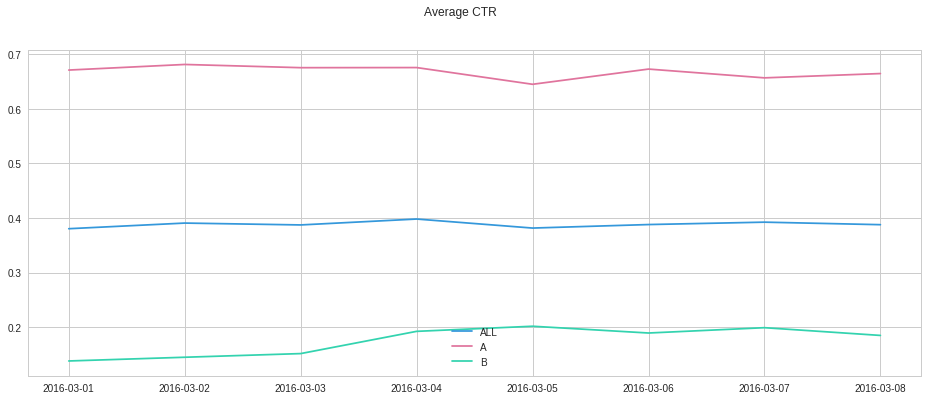

In [5]:
fig = plt.figure(figsize=(16, 6))
plt.plot(
    df1[df1.action_visitPage > 0].groupby("timestamp").count().session_id /
    df1.groupby("timestamp").count().session_id,
    label="ALL",
    color=cpal[0])
plt.plot(
    df1[(df1.action_visitPage > 0)
        & (df1.group_a > 0)].groupby("timestamp").count().session_id / df1[(
            df1.group_a > 0)].groupby("timestamp").count().session_id,
    label="A",
    color=cpal[1])
plt.plot(
    df1[(df1.action_visitPage > 0)
        & (df1.group_a == 0)].groupby("timestamp").count().session_id / df1[(
            df1.group_a == 0)].groupby("timestamp").count().session_id,
    label="B",
    color=cpal[2])
fig.suptitle(
    t="Average CTR")
plt.legend();

#### <dd>2. Which results do people tend to try first? How does it change day-to-day?</dd>

The vast majority of page clicks are geared towards the first results.

In [6]:
print(
    "Proportion of clicks on one of the first 10 results out of all results %s%%."
    % (100 * np.round(
        len(df[df.result_position <= 10]) / len(df[df.result_position > 0]),3)
       ))

Proportion of clicks on one of the first 10 results out of all results 96.6%.


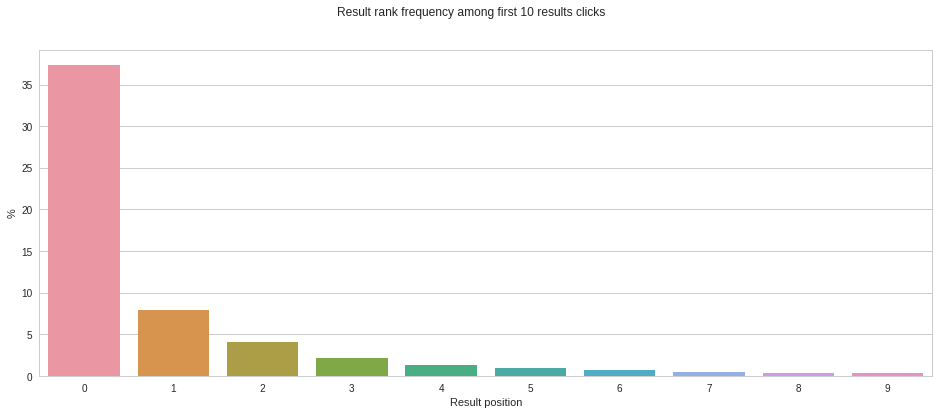

In [7]:
fig = plt.figure(figsize=(16, 6))
ax = sns.barplot(
    x="result_position",
    y="result_position",
    data=df[df.result_position <= 10],
    estimator=lambda x: len(x) / len(df) * 100, )
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
fig.suptitle(
    t="Result rank frequency among first 10 results clicks")
ax.set(xlabel="Result position")
ax.set(ylabel="%");

User behind session 5e0036c1b3bcd196 clicked on result **#4103**. It seems likely that this user is checking last search results first.

In [8]:
df[df.result_position == df.result_position.max()].session_id.values[
    0], df[df.session_id == df[df.result_position == df.result_position.max()]
           .session_id.values[0]].result_position.unique()

('5e0036c1b3bcd196', array([4087.,   nan, 3972., 3895., 4103., 3955.]))

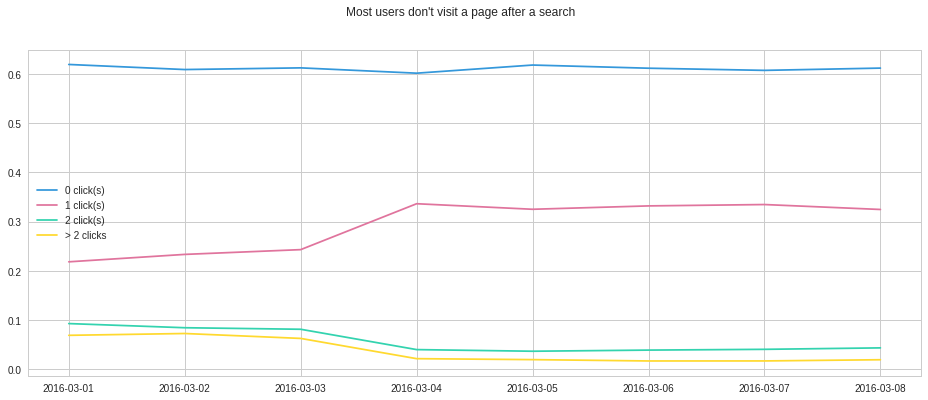

In [9]:
fig = plt.figure(figsize=(16, 6))

y = 2

for i in range(y + 1):
    plt.plot(
        df1[df1.action_visitPage == i].groupby("timestamp").count().session_id
        / df1.groupby("timestamp").count().session_id,
        label=str(i) + " click(s)",
        color=cpal[i])
plt.plot(
    df1[df1.action_visitPage > y].groupby("timestamp").count().session_id /
    df1.groupby("timestamp").count().session_id,
    label="> " + str(y) + " clicks",
    color=cpal[y + 1])
fig.suptitle(
    t="Most users don't visit a page after a search")
plt.legend();

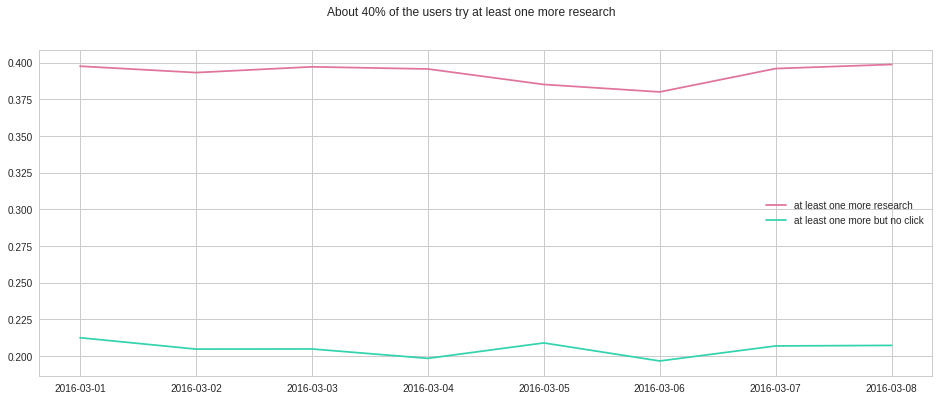

In [10]:
fig = plt.figure(figsize=(16, 6))
plt.plot(
    df1[df1.action_searchResultPage >= 2].groupby("timestamp").count().session_id /
    df1.groupby("timestamp").count().session_id,
    label="at least one more research",
    color=cpal[1])
plt.plot(
    df1[(df1.action_searchResultPage >= 2) & (df1.action_visitPage == 0)].groupby("timestamp").count().session_id /
    df1.groupby("timestamp").count().session_id,
    label="at least one more but no click",
    color=cpal[2])
fig.suptitle(
    t="About 40% of the users try at least one more research")
plt.legend();

#### <dd>3. What is our daily overall zero results rate? How does it vary between the groups?</dd>

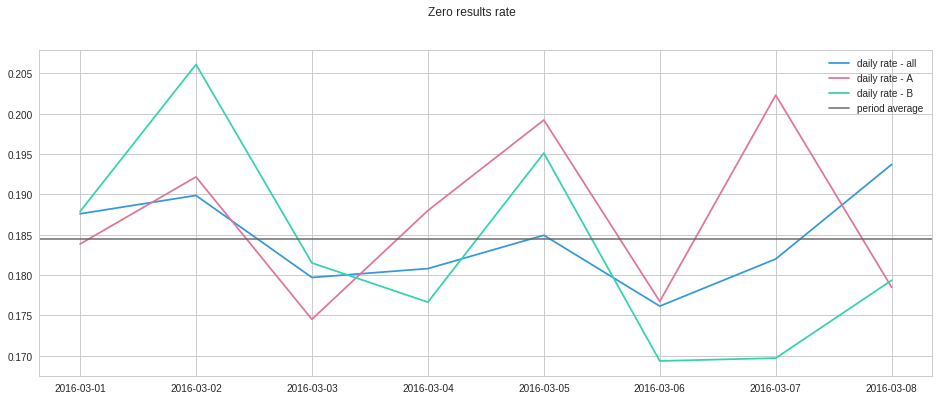

In [11]:
fig = plt.figure(figsize=(16, 6))
plt.plot(df[(df.action_searchResultPage == 1) & (df.n_results == 0)].groupby(
        pd.Grouper(key="timestamp", freq="D")).count().action_searchResultPage
    / df[df.action_searchResultPage == 1].groupby(
        pd.Grouper(key="timestamp", freq="D")).count().action_searchResultPage,
    label="daily rate - all")
plt.plot(df[(df.action_searchResultPage == 1) & (df.n_results == 0) &
       (df1.group_a > 0)].groupby(pd.Grouper(
           key="timestamp", freq="D")).count().action_searchResultPage /
    df[(df.action_searchResultPage == 1) & (df1.group_a > 0)].groupby(
        pd.Grouper(key="timestamp", freq="D")).count().action_searchResultPage,
    label="daily rate - A")
plt.plot(df[(df.action_searchResultPage == 1) & (df.n_results == 0) &
       (df1.group_a == 0)].groupby(pd.Grouper(
           key="timestamp", freq="D")).count().action_searchResultPage /
    df[(df.action_searchResultPage == 1) & (df1.group_a == 0)].groupby(
        pd.Grouper(key="timestamp", freq="D")).count().action_searchResultPage,
    label="daily rate - B")
fig.suptitle(t="Zero results rate")
plt.axhline(
    y=len(df[(df.action_searchResultPage == 1) & (df.n_results == 0)]) / len(
        df[df.action_searchResultPage == 1]),
    color="#635f62", alpha=.8, label="period average")
plt.legend()

#### <dd>4. Let session length be approximately the time between the first event and the last event in a session. Choose a variable from the dataset and describe its relationship to session length. Visualize the relationship.</dd>

In [12]:
checkin_max = df.groupby("session_id").checkin.max()
n_visits_sum = df.groupby("session_id").action_visitPage.sum()
rel_df = pd.concat([checkin_max, n_visits_sum], axis=1).fillna(0)

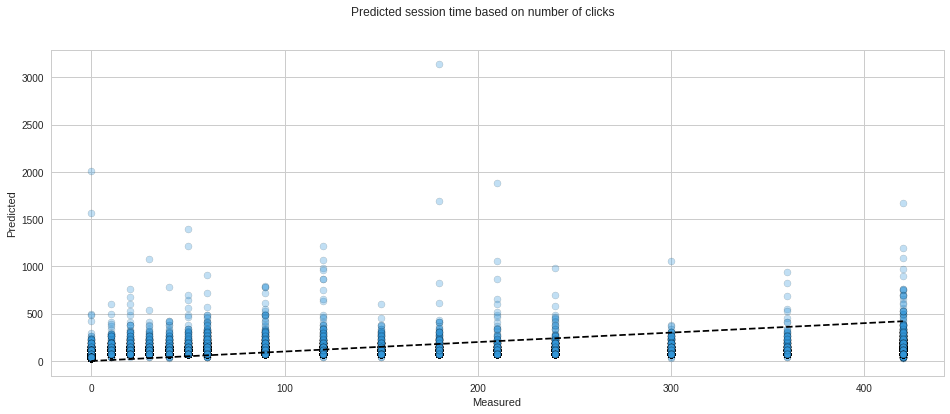

In [13]:
from sklearn import datasets
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model

lr = linear_model.Lasso()
y = rel_df.checkin.values

predicted = cross_val_predict(lr, rel_df[rel_df.columns[1:]].values, y, cv=10)

fig, ax = plt.subplots(figsize=(16, 6))
ax.scatter(y, predicted, color=cpal[0], edgecolors=(0, 0, 0), alpha=.3)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--')
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
fig.suptitle(t="Predicted session time based on number of clicks");

#### <dd>5. Summarize your findings in an executive summary.</dd>

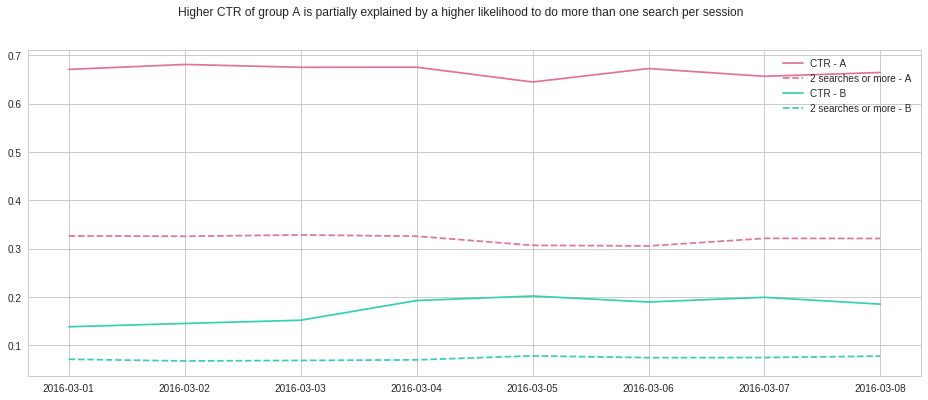

In [14]:
fig = plt.figure(figsize=(16, 6))
plt.plot(
    df1[(df1.action_visitPage > 0)
        & (df1.group_a > 0)].groupby("timestamp").count().session_id / df1[(
            df1.group_a > 0)].groupby("timestamp").count().session_id,
    label="CTR - A",
    color=cpal[1])
plt.plot(
    df1[(df1.action_searchResultPage >= 2)
        & (df1.group_a)].groupby("timestamp").count().session_id /
    df1.groupby("timestamp").count().session_id,
    linestyle="--",
    label="2 searches or more - A",
    color=cpal[1])
plt.plot(
    df1[(df1.action_visitPage > 0)
        & (df1.group_a == 0)].groupby("timestamp").count().session_id / df1[(
            df1.group_a == 0)].groupby("timestamp").count().session_id,
    label="CTR - B",
    color=cpal[2])
plt.plot(
    df1[(df1.action_searchResultPage >= 2)
        & (df1.group_a == 0)].groupby("timestamp").count().session_id /
    df1.groupby("timestamp").count().session_id,
    label="2 searches or more - B",
    linestyle="--",
    color=cpal[2])
fig.suptitle(
    t="Higher CTR of group A is partially explained by a higher likelihood to do more than one search per session"
)
plt.legend()

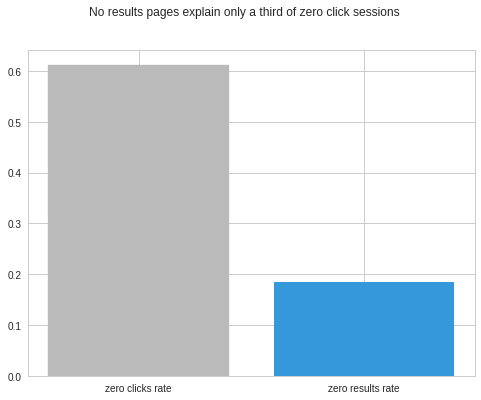

In [15]:
rates = [len(df1[df1.action_visitPage == 0].session_id) / len(df1.session_id),
len(df[(df.action_searchResultPage == 1) & (df.n_results == 0)]) / len(
        df[df.action_searchResultPage == 1])]

fig, ax = plt.subplots(figsize=(8, 6))
barlist = plt.bar([0,1], rates)
barlist[0].set_color(cpal[7])
plt.xticks([0,1], ["zero clicks rate", "zero results rate"])
fig.suptitle(t="No results pages explain only a third of zero click sessions");